In [2]:
import numpy as np
import pandas as pd
import six
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import string
import time
import os
from tqdm import tqdm


from sklearn.model_selection import train_test_split

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model, Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense, Flatten, Embedding
from keras.layers.convolutional import Conv1D, MaxPooling1D
import keras

os.environ["CUDA_VISIBLE_DEVICES"]="0";  

%matplotlib inline

In [3]:
# Read data
DATA_PATH = 'data/scraped/names_prices_descriptions.pickle'
df_wines = pd.read_pickle(DATA_PATH)

# Clean pricing data
new_prices = []
for row in df_wines['price']:
    try:
        new_prices.append(row[0])
    except:
        new_prices.append(np.nan)
df_wines['price'] = new_prices
df_wines.dropna(subset=['name', 'price'], inplace=True)
df_wines['price'] = df_wines['price'].astype(str)
df_wines = df_wines[df_wines['price'] != '']
df_wines = df_wines[~df_wines['price'].str.contains(' ')]
df_wines['price'] = df_wines['price'].astype(float)

print(df_wines.shape)
df_wines.head()

(15201, 3)


,name,price,description
0,Hall Napa Valley Cabernet Sauvignon 2013,54.99,"Dark garnet in color, the 2013 HALL Napa Valle..."
1,Rombauer Chardonnay 2017,36.99,Rombauer Vineyards was founded in 1982 by Koer...
2,Antinori Tignanello 2015,124.99,#24
3,Borne of Fire Cabernet Sauvignon 2016,19.99,"Like a phoenix rising from the ashes, we have ..."
4,Torbreck Woodcutters Shiraz 2017,21.99,This wine reflects the up and coming Shiraz vi...


In [4]:
NUM_WORDS = 1000

# create/fit tokenizer, convert to sequences and pad for model input
docs = df_wines['name'].astype(str)
t = Tokenizer(num_words=NUM_WORDS)
t.fit_on_texts(docs)
encoded_seq = t.texts_to_sequences(docs)
training_max_length = max([len(s) for s in encoded_seq])

# define vocabulary size (largest integer value)
vocab_size = len(t.word_index) + 1
print(vocab_size)

X = pad_sequences(encoded_seq, maxlen=training_max_length, padding='post')
y = df_wines['price']

# Split out the training/testing datasets
X_train,\
X_test,\
y_train,\
y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Print some statistics 
print("Wine Prices: mean=${:.2f} median=${:.2f}".format(df_wines['price'].mean(),df_wines['price'].median()))
print("Vocab size: ", vocab_size)
print("Sample count: ", len(encoded_seq))
print("Length of first sequence: ", len(encoded_seq[0]))
print("Max sequence length: ", training_max_length)
print("Sample: ", encoded_seq[0][:10])
print("X: ",X.shape)
print("y: ",y.shape)

10078
Wine Prices: mean=$73.53 median=$27.99
Vocab size:  10078
Sample count:  15201
Length of first sequence:  6
Max sequence length:  14
Sample:  [311, 60, 21, 7, 4, 10]
X:  (15201, 14)
y:  (15201,)


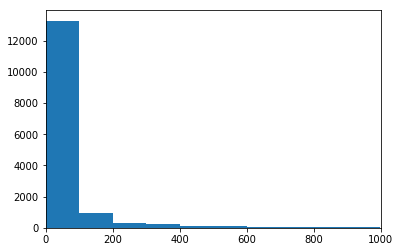

In [8]:
plt.close()
plt.hist(y[y<1000])
plt.xlim(0,1000)
plt.show()

In [9]:
LOSS_METRIC = 'mean_squared_error'

# Define model
model = Sequential()
model.add(Embedding(vocab_size, NUM_WORDS, input_length=training_max_length))
model.add(Conv1D(filters=16, kernel_size=8, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='linear'))
print(model.summary())

#d_model = Sequential()
#d_model.add(Embedding(vocab_size, 250, input_length=max_length))
#d_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
#d_model.add(Dense(64, kernel_initializer='normal',activation='relu'))
#d_model.add(Dense(32, kernel_initializer='normal',activation='relu'))
#d_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

checkpoint = ModelCheckpoint('data/models_weights/model_price.h5', 
                             monitor=LOSS_METRIC, 
                             verbose=0, 
                             save_best_only=True, 
                             mode='min')
early_stopping = EarlyStopping(monitor=LOSS_METRIC,
                               patience=20,
                               mode='min')
tboard = keras.callbacks.TensorBoard(log_dir='./Graph',
                                     histogram_freq=0, 
                                     write_graph=True, 
                                     write_images=True)
callbacks_list = [checkpoint,early_stopping,tboard]

# compile network
model.compile(loss=LOSS_METRIC, 
              optimizer='adam',
              metrics=['mse']
              )
# fit network
model.fit(X_train, 
          y_train, 
          epochs=500, 
          callbacks=callbacks_list,
          verbose=2)

# Save weights
model.save('data/models_weights/model_price.h5')

W0913 11:51:27.053722  9428 deprecation_wrapper.py:119] From c:\users\david\documents\github\this-wine-does-not-exist\.venv_w10\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0913 11:51:27.079676  9428 deprecation_wrapper.py:119] From c:\users\david\documents\github\this-wine-does-not-exist\.venv_w10\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0913 11:51:27.086678  9428 deprecation_wrapper.py:119] From c:\users\david\documents\github\this-wine-does-not-exist\.venv_w10\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0913 11:51:27.112590  9428 deprecation_wrapper.py:119] From c:\users\david\documents\github\this-wine-does-not-exist\.venv_w10\lib\site-packages\keras\backend\tensorflow_backe

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 14, 1000)          10078000  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 7, 16)             128016    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 3, 16)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 48)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                490       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 10,206,517
Trainable params: 10,206,517
Non-trainable params: 0
________________________________________________________________

W0913 11:51:28.272994  9428 deprecation_wrapper.py:119] From c:\users\david\documents\github\this-wine-does-not-exist\.venv_w10\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0913 11:51:28.373746  9428 deprecation_wrapper.py:119] From c:\users\david\documents\github\this-wine-does-not-exist\.venv_w10\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0913 11:51:28.437576  9428 deprecation_wrapper.py:119] From c:\users\david\documents\github\this-wine-does-not-exist\.venv_w10\lib\site-packages\keras\backend\tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.

W0913 11:51:30.988781  9428 deprecation_wrapper.py:119] From c:\users\david\documents\github\this-wine-does-not-exist\.venv_w10\lib\site-packages\keras\callbacks.py:850: The name tf.summary.merge_all is d

Epoch 1/500
 - 4s - loss: 35236.1823 - mean_squared_error: 35236.1823
Epoch 2/500
 - 3s - loss: 24720.4729 - mean_squared_error: 24720.4729
Epoch 3/500
 - 3s - loss: 17257.0669 - mean_squared_error: 17257.0669
Epoch 4/500
 - 2s - loss: 12326.1304 - mean_squared_error: 12326.1304
Epoch 5/500
 - 2s - loss: 10504.8031 - mean_squared_error: 10504.8031
Epoch 6/500
 - 2s - loss: 9501.8761 - mean_squared_error: 9501.8761
Epoch 7/500
 - 2s - loss: 8907.1325 - mean_squared_error: 8907.1325
Epoch 8/500
 - 2s - loss: 8179.1270 - mean_squared_error: 8179.1270
Epoch 9/500
 - 2s - loss: 8157.2014 - mean_squared_error: 8157.2014
Epoch 10/500
 - 2s - loss: 7595.3629 - mean_squared_error: 7595.3629
Epoch 11/500
 - 2s - loss: 7189.3797 - mean_squared_error: 7189.3797
Epoch 12/500
 - 2s - loss: 6854.1372 - mean_squared_error: 6854.1372
Epoch 13/500
 - 2s - loss: 6501.6095 - mean_squared_error: 6501.6095
Epoch 14/500
 - 2s - loss: 6320.3410 - mean_squared_error: 6320.3410
Epoch 15/500
 - 2s - loss: 5969.9

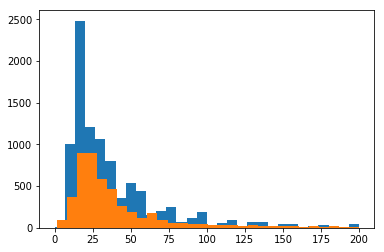

In [10]:
y_model = model.predict(X_test)
y_model = pd.Series([item[0] for item in y_model])
y_model_residuals = y_model - y_test

plt.hist(y_train[y_train < 200], bins=30)
plt.hist(y_model[y_model < 200], bins=30)
plt.show()


In [17]:
# Sample some predicted wines and prices
predictions = model.predict(X_test)
for i in range(1,4):
    print(t.sequences_to_texts(X_test)[i])
    print(predictions[i])
    print('\n')

cava reserva rose 2016
[15.056347]


brunello di montalcino 2013
[66.90527]


peter vineyard zinfandel 2014
[37.045444]




## Predict prices on fake wines

In [18]:
# Read in fake wine names and descriptions
df_fake_wines = pd.read_csv('data/fake/DESC_v1_2.csv',
                            sep='|',
                            low_memory=False)
df_fake_wines = pd.read_excel('data/fake/names_descriptions.xlsx')

# Run the encodings as was done with training data
encoded_seq = t.texts_to_sequences(df_fake_wines['description'])
max_length = max([len(s) for s in encoded_seq])
fake_X = pad_sequences(encoded_seq, maxlen=training_max_length, padding='post')

print("Sample count: ", len(encoded_seq))
print("Length of first sequence: ", len(encoded_seq[0]))
print("Sample: ", encoded_seq[0][:10])

assert X_train.shape[1] == fake_X.shape[1]
fake_predictions = model.predict(fake_X)

# Save to DF and CSV
df_fake_wines['price'] = fake_predictions.astype(int)
df_fake_wines['price'] = abs(df_fake_wines['price'])
df_fake_wines.to_excel('data/fake/fake_names_descs_prices.xlsx', index=False)

Sample count:  1275
Length of first sequence:  11
Sample:  [50, 86, 39, 122, 7, 4, 39, 7, 135, 29]


In [19]:
df_fake_wines.head()

,name,description,price
0,Joseph Carr Reveliste Cinsault 2013,"Tart bu! Precision wine is a versatile, Merlo...",39
1,Carol Shelton Roche TBredi 2016,Closes possesses a pure-lie agnio of Californ...,56
2,Finca Bolgheri Pinot Grigio 2018,Pair with a first-good to preserve the fruit...,37
3,Domaine de Cristict Chardonnay 2016,\nThere are a rich wine was born in barrel and...,56
4,Domaine Dujac Fils &amp; Pere Chambolle Rouge ...,\nTenuta IX C Went Co Recre vineyard has arou...,6


### Remove wines with less than 300 length descriptions

In [20]:
descriptions_lengths = [len(row) for row in df_fake_wines['description']]
df_fake_wines_300 = df_fake_wines[pd.Series(descriptions_lengths) > 300]
df_fake_wines_300.to_excel('data/fake/fake_names_descs_prices.xlsx', index=False)
print(df_fake_wines_300.shape)

(999, 3)
